In [ ]:
# Introduction

In [36]:
# Import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random
from scipy import signal

from sklearn.model_selection import train_test_split

## Download the data
http://mindbigdata.com/opendb/index.html

In [7]:
%%bash
wget -q http://mindbigdata.com/opendb/MindBigData-IN-v1.06.zip
mkdir -p DATA
unzip -qq MindBigData-IN-v1.06.zip
mv IN.txt DATA/
rm MindBigData-IN-v1.06.zip

In [ ]:
# Load and clean data

In [2]:
PATH_DATA="DATA/IN.txt"

with open(PATH_DATA,'r') as f:
    print(f.readline())

1142043	173652	IN	AF3	0	256	4259.487179,4237.948717,4247.179487,4242.051282,4233.333333,4251.282051,4232.820512,4234.358974,4224.615384,4219.487179,4249.743589,4238.461538,4245.641025,4244.615384,4223.076923,4240.512820,4234.358974,4240.512820,4235.384615,4224.102564,4255.384615,4243.589743,4243.589743,4248.205128,4226.666666,4244.102564,4228.717948,4225.641025,4236.923076,4208.717948,4226.153846,4234.871794,4234.871794,4245.641025,4233.846153,4263.076923,4261.025641,4244.615384,4261.025641,4242.051282,4243.589743,4233.333333,4221.025641,4241.538461,4235.384615,4250.256410,4235.897435,4221.538461,4268.717948,4257.435897,4238.974358,4232.307692,4218.461538,4244.615384,4236.410256,4235.384615,4246.666666,4238.461538,4252.820512,4234.358974,4232.820512,4247.692307,4234.871794,4260.000000,4249.230769,4233.846153,4251.282051,4249.230769,4272.820512,4265.128205,4256.410256,4265.641025,4233.333333,4253.846153,4256.923076,4238.461538,4265.641025,4256.923076,4254.871794,4251.794871,4244.615384,

In [3]:
df=pd.read_csv(PATH_DATA,delimiter="\t",header=None,names=["id","event","device","channel","code","size","data"])
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65250 entries, 0 to 65249
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       65250 non-null  int64 
 1   event    65250 non-null  int64 
 2   device   65250 non-null  object
 3   channel  65250 non-null  object
 4   code     65250 non-null  int64 
 5   size     65250 non-null  int64 
 6   data     65250 non-null  object
dtypes: int64(4), object(3)
memory usage: 3.5+ MB
None


,id,event,device,channel,code,size,data
0,1142043,173652,IN,AF3,0,256,"4259.487179,4237.948717,4247.179487,4242.05128..."
1,1142044,173652,IN,AF4,0,256,"4103.076923,4100.512820,4102.564102,4087.69230..."
2,1142045,173652,IN,T7,0,256,"4245.128205,4218.461538,4242.051282,4245.12820..."
3,1142046,173652,IN,T8,0,256,"4208.717948,4188.717948,4204.102564,4198.46153..."
4,1142047,173652,IN,PZ,0,256,"4189.230769,4203.589743,4188.717948,4186.66666..."


In [23]:
df.id.nunique()

65250

In [24]:
df.event.nunique()

13050

In [26]:
df.channel.nunique()

5

<AxesSubplot:>

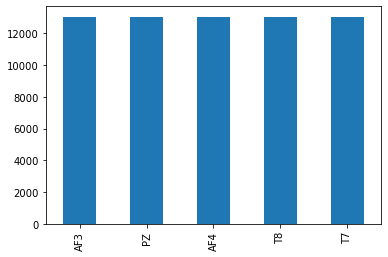

In [32]:
df.channel.value_counts().plot.bar()

In [30]:
df.code.nunique()

10

<AxesSubplot:>

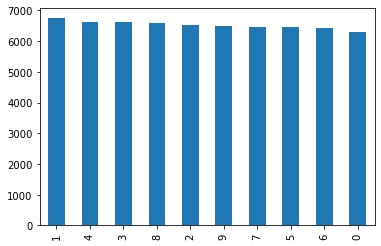

In [31]:
df.code.value_counts().plot.bar()

In [50]:
df["size"].mean()

244.13532567049808

In [51]:
df["size"].std()

31.935014214264896

### Dealing with the data values

In [4]:
df.data=df.data.apply(lambda x: [float(i) for i in x.split(",")])

In [5]:
df.data.apply(np.mean).agg(["mean","std"])

mean    4276.380742
std       37.388607
Name: data, dtype: float64

In [6]:
df.data.apply(np.std).agg(["mean","std"])

mean    19.463488
std     24.060789
Name: data, dtype: float64

In [5]:
event_id=173652
df.query(f"event=={event_id}")

,id,event,device,channel,code,size,data
0,1142043,173652,IN,AF3,0,256,"[4259.487179, 4237.948717, 4247.179487, 4242.0..."
1,1142044,173652,IN,AF4,0,256,"[4103.076923, 4100.51282, 4102.564102, 4087.69..."
2,1142045,173652,IN,T7,0,256,"[4245.128205, 4218.461538, 4242.051282, 4245.1..."
3,1142046,173652,IN,T8,0,256,"[4208.717948, 4188.717948, 4204.102564, 4198.4..."
4,1142047,173652,IN,PZ,0,256,"[4189.230769, 4203.589743, 4188.717948, 4186.6..."


In [6]:
# generate times column
df["time"]=df.apply(lambda row: list(np.arange(0,2,1/row.size)),axis=1)

In [7]:
def plot_event(event_id):
    df_aux=df.query(f"event=={event_id}")
    df_plot=pd.DataFrame(dict(zip(df_aux["channel"],df_aux["data"])))
    plt.figure(figsize=(10,10))
    sns.lineplot(data=df_plot)
    plt.title(f"Event: {df_aux.iloc[0].event} - Digit: {df_aux.iloc[0].code}")

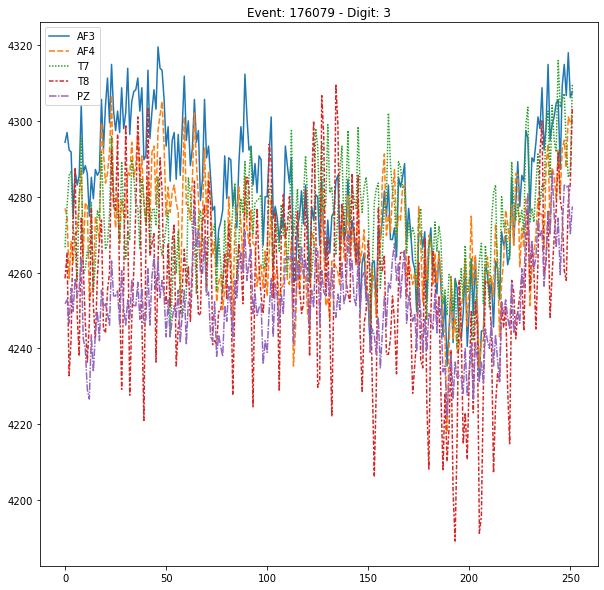

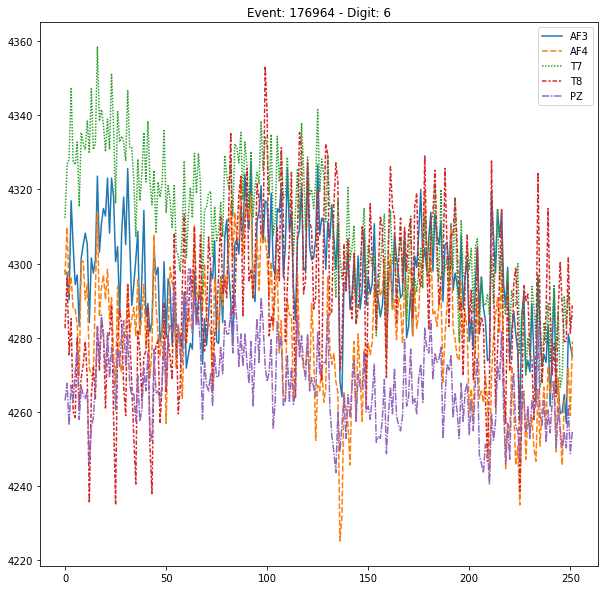

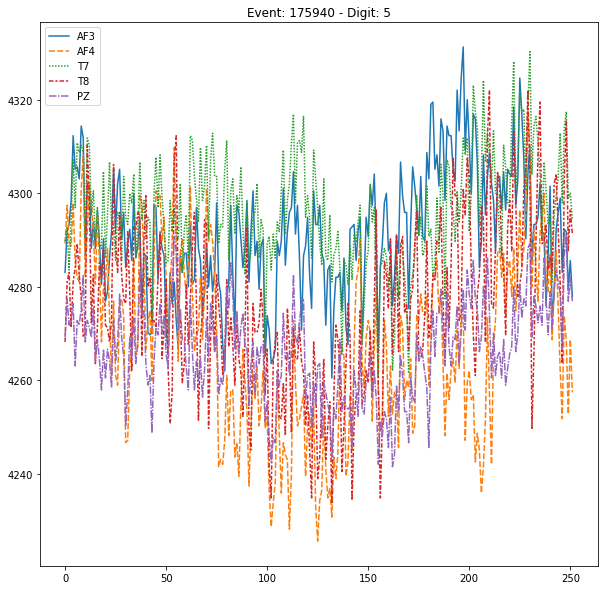

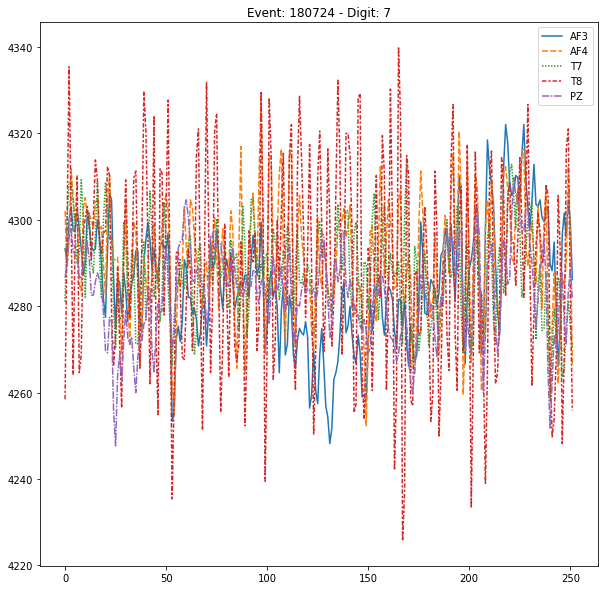

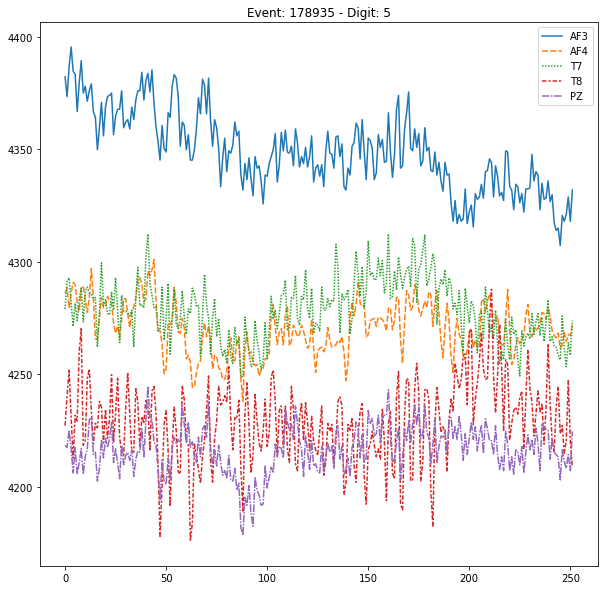

In [8]:
for ev_id in random.sample(df.event.unique().tolist(),5):
    plot_event(ev_id)

## Modeling

In [80]:
def get_sample(event_id):
    df_aux=df.query(f"event=={event_id}")
    return pd.DataFrame(dict(zip(df_aux["channel"],df_aux["data"]))).values.T.reshape(1,5,-1)

In [81]:
get_sample(event_id).shape

(1, 5, 256)

In [61]:
def get_values_df(df_aux,resample_value=272):
    df_aux=df_aux.sort_values(by="channel")
    channels_values=pd.DataFrame(dict(zip(df_aux["channel"],df_aux["data"]))).values.T.reshape(5,-1)
    channels_values=signal.resample(channels_values,272,axis=1)
    label=df_aux.code.iloc[0]
    return pd.Series({'eeg': channels_values, 'label': label}) #https://stackoverflow.com/questions/10751127/returning-multiple-values-from-pandas-apply-on-a-dataframe


In [62]:
df.head()

,id,event,device,channel,code,size,data,time
0,1142043,173652,IN,AF3,0,256,"[4259.487179, 4237.948717, 4247.179487, 4242.0...","[0.0, 0.14285714285714285, 0.2857142857142857,..."
1,1142044,173652,IN,AF4,0,256,"[4103.076923, 4100.51282, 4102.564102, 4087.69...","[0.0, 0.14285714285714285, 0.2857142857142857,..."
2,1142045,173652,IN,T7,0,256,"[4245.128205, 4218.461538, 4242.051282, 4245.1...","[0.0, 0.14285714285714285, 0.2857142857142857,..."
3,1142046,173652,IN,T8,0,256,"[4208.717948, 4188.717948, 4204.102564, 4198.4...","[0.0, 0.14285714285714285, 0.2857142857142857,..."
4,1142047,173652,IN,PZ,0,256,"[4189.230769, 4203.589743, 4188.717948, 4186.6...","[0.0, 0.14285714285714285, 0.2857142857142857,..."


In [63]:
df_preprocessed=df.groupby(['event']).apply(lambda row: get_values_df(row)).reset_index()

In [64]:
## Train test split
ids_train, ids_test, y_train, y_test=train_test_split(df_preprocessed.index,df_preprocessed.label,test_size=0.2,random_state=11)

In [65]:
y_train.value_counts()/sum(y_train.value_counts())

1    0.104215
4    0.102299
8    0.101341
7    0.101149
3    0.100575
2    0.099617
9    0.099617
5    0.098755
6    0.097510
0    0.094923
Name: label, dtype: float64

In [66]:
y_test.value_counts()/sum(y_test.value_counts())

3    0.103831
0    0.103448
6    0.102299
2    0.102299
5    0.100000
9    0.099617
1    0.099617
8    0.099617
4    0.098084
7    0.091188
Name: label, dtype: float64

In [67]:
df_train=df_preprocessed.loc[ids_train].reset_index(drop=True)
df_test=df_preprocessed.loc[ids_train].reset_index(drop=True)

In [ ]:
## Normalize data

## Dataset class and dataloaders

In [68]:
from torch.utils.data import Dataset, DataLoader
import torch

class BrainMNISTDataset(Dataset):
    """Brain MNIST dataset."""

    def __init__(self, df, transform=None):
        """
        Args:
            df (pd.DataFrame): DataFrame with data
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.eeg_frame = df
        self.transform = transform

    def __len__(self):
        return len(self.eeg_frame)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        sample = {'eeg': self.eeg_frame.loc[idx].eeg, 'label': self.eeg_frame.loc[idx].label}

        if self.transform:
            sample = self.transform(sample)

        return sample

In [69]:
eeg_dataset = BrainMNISTDataset(df=df_preprocessed)

for i in range(len(eeg_dataset)):
    sample = eeg_dataset[i]
    print(sample)
    if i>3: break


{'eeg': array([[4259.487179  , 4238.96319326, 4244.77003846, ..., 4277.08999777,
        4276.41794918, 4255.69758417],
       [4103.076923  , 4098.83154062, 4104.60866576, ..., 4226.8962367 ,
        4236.39821499, 4203.76551097],
       [4189.230769  , 4202.10520142, 4193.05892362, ..., 4197.31074089,
        4197.5021685 , 4228.54556014],
       [4245.128205  , 4218.76524222, 4238.14161653, ..., 4262.08024311,
        4266.67280782, 4263.73007758],
       [4208.717948  , 4189.9668821 , 4200.3693661 , ..., 4203.87692153,
        4208.46616666, 4184.56686408]]), 'label': 0}
{'eeg': array([[4273.846153  , 4265.08722153, 4268.99369462, ..., 4310.5786153 ,
        4308.84526367, 4317.85860249],
       [4233.846153  , 4248.38241852, 4265.34361879, ..., 4351.10023095,
        4334.07514012, 4326.71060121],
       [4208.717948  , 4214.73865279, 4234.01731484, ..., 4213.92765905,
        4238.15318287, 4223.28111226],
       [4301.025641  , 4302.2183315 , 4293.02955923, ..., 4290.15347102,
 

In [70]:
dataloader = DataLoader(eeg_dataset, batch_size=32, shuffle=True, num_workers=0)

for i_batch, sample_batched in enumerate(dataloader):
    print(i_batch, sample_batched['eeg'].size(),
          sample_batched['label'].size())
    if i_batch > 10: break

0 torch.Size([32, 5, 272]) torch.Size([32])
1 torch.Size([32, 5, 272]) torch.Size([32])
2 torch.Size([32, 5, 272]) torch.Size([32])
3 torch.Size([32, 5, 272]) torch.Size([32])
4 torch.Size([32, 5, 272]) torch.Size([32])
5 torch.Size([32, 5, 272]) torch.Size([32])
6 torch.Size([32, 5, 272]) torch.Size([32])
7 torch.Size([32, 5, 272]) torch.Size([32])
8 torch.Size([32, 5, 272]) torch.Size([32])
9 torch.Size([32, 5, 272]) torch.Size([32])
10 torch.Size([32, 5, 272]) torch.Size([32])
11 torch.Size([32, 5, 272]) torch.Size([32])


In [71]:
## Train and test dataloaders
trainloader = DataLoader(BrainMNISTDataset(df=df_train), batch_size=32, shuffle=True, num_workers=0)
testloader = DataLoader(BrainMNISTDataset(df=df_test), batch_size=32, shuffle=True, num_workers=0)

In [87]:
import torch.nn as nn

# https://rosenfelder.ai/multi-input-neural-network-pytorch/
# https://pytorch.org/tutorials/recipes/recipes/defining_a_neural_network.html

#X = get_sample(event_id)
#print(f"Shape of input values: {X.shape}")

class network(nn.Module):
    def __init__(self, input_channels, output_units):
        super(network, self).__init__()
        self.layer1 = nn.Conv1d(in_channels=input_channels, out_channels=20, kernel_size=5, stride=2)
        self.act1 = nn.ReLU()
        self.layer2 = nn.Conv1d(in_channels=20, out_channels=10, kernel_size=1)
        self.act2 = nn.ReLU()
        self.out = nn.Linear(1340, output_units)
    def forward(self, x):
        x = self.layer1(x)
        x = self.act1(x)
        x = self.layer2(x)
        x = self.act2(x)
        x = torch.flatten(x, 1)
        x = self.out(x)

        log_probs = torch.nn.functional.log_softmax(x, dim=1)

        return log_probs

model = network(input_channels=5,output_units=10).double()
#print(model(torch.tensor(X)).shape)

In [83]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [ ]:
# Training loop

NUM_EPOCHS=10

for epoch in range(NUM_EPOCHS):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, sample_batched in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = sample_batched['eeg'],sample_batched['label']

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 20 == 19:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,    20] loss: 3.793
[1,    40] loss: 3.881
[1,    60] loss: 3.702
[1,    80] loss: 3.909
[1,   100] loss: 3.704
[1,   120] loss: 3.929
[1,   140] loss: 3.842
[1,   160] loss: 3.822
[1,   180] loss: 3.804
[1,   200] loss: 3.776
[1,   220] loss: 3.648
[1,   240] loss: 3.760
[1,   260] loss: 3.857
[1,   280] loss: 3.797
[1,   300] loss: 3.726
[1,   320] loss: 3.750
[2,    20] loss: 3.722
[2,    40] loss: 3.816
[2,    60] loss: 3.850
[2,    80] loss: 3.868
[2,   100] loss: 3.851
[2,   120] loss: 3.897
[2,   140] loss: 3.700
[2,   160] loss: 3.746
[2,   180] loss: 3.666
[2,   200] loss: 3.936
[2,   220] loss: 3.984
[2,   240] loss: 3.771
[2,   260] loss: 3.823
[2,   280] loss: 3.763
[2,   300] loss: 3.657
[2,   320] loss: 3.721
[3,    20] loss: 3.642
[3,    40] loss: 3.793
[3,    60] loss: 3.672
[3,    80] loss: 3.809
[3,   100] loss: 3.776
[3,   120] loss: 3.778
[3,   140] loss: 3.907
[3,   160] loss: 3.932
[3,   180] loss: 3.800
[3,   200] loss: 3.862
[3,   220] loss: 3.897
[3,   240] 